<a href="https://colab.research.google.com/github/suinkangme/COMP432-GroupI/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. DATA LOADING AND PREPROCESSING**

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --fuzzy "https://drive.google.com/file/d/1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY/view?usp=drive_link"

Downloading...
From: https://drive.google.com/uc?id=1M0uN1jbjbOh3b6fjDfe2qrNnYSJrgfwY
To: /content/Dataset_1.zip
100% 831M/831M [00:09<00:00, 87.4MB/s]


In [ ]:
!unzip /content/Dataset_1.zip

Streaming output truncated to the last 5000 lines.
  inflating: Colorectal Cancer/MUS/MUS-CIHSSWPV.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIHWTRHA.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIILSKST.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIIMVVTT.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIITQWPP.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIKANVTM.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIKKELKA.tif  
  inflating: Colorectal Cancer/MUS/MUS-CILPKGCQ.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIMWFGFH.tif  
  inflating: Colorectal Cancer/MUS/MUS-CINGCMFK.tif  
  inflating: Colorectal Cancer/MUS/MUS-CINGLGES.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIPMCCVS.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIPNEIRF.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIQAGCRV.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIQFFGDI.tif  
  inflating: Colorectal Cancer/MUS/MUS-CIRAICLW.tif  
  inflating: Colorectal Cancer/MUS/MUS-CISHTCWQ.tif  
  inflating: Colorectal Cancer/

In [ ]:
dataset_dir = '/content/Colorectal Cancer'

In [ ]:
# Define transforms
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=dataset_dir)

In [18]:
# Split dataset indices
train_indices, test_indices = train_test_split(list(range(len(full_dataset))), test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1)  # 10% of 80% = 8% of the whole

In [19]:
# Create subsets
train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

In [ ]:
# Apply transforms to subsets using a custom Dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [20]:
# Create a DataLoader for original images
original_dataset = CustomDataset(train_subset, transform=transform)
original_loader = DataLoader(original_dataset, batch_size=32, shuffle=False)

In [21]:
train_dataset = CustomDataset(train_subset, transform=transform)
val_dataset = CustomDataset(val_subset, transform=transform)
test_dataset = CustomDataset(test_subset, transform=transform)

In [22]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

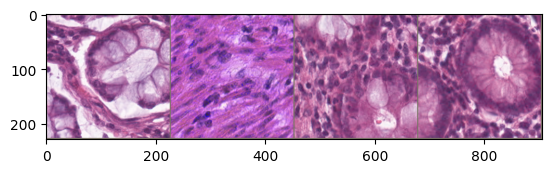

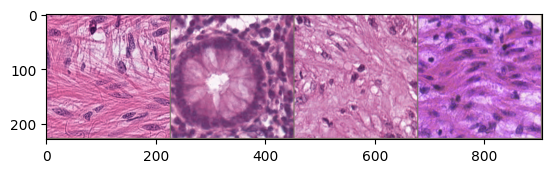

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Function to show images
def imshow(img):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(npimg)
    plt.show()

# Fetch a batch of original images
images_original, _ = next(iter(original_loader))

# Fetch a batch of augmented images
images_augmented, _ = next(iter(train_loader))

# Display original images
imshow(torchvision.utils.make_grid(images_original[:4]))

# Display augmented images
imshow(torchvision.utils.make_grid(images_augmented[:4]))

**2. SET UP RESNET MODEL**

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Model setup
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 7
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(100 * total_correct / total)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * val_correct / val_total)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Loss: {val_losses[-1]}, Val Acc: {val_accuracies[-1]}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/7, Train Loss: 0.5183729520550481, Train Acc: 78.86574074074075, Val Loss: 0.7292686184247335, Val Acc: 64.79166666666667
Epoch 2/7, Train Loss: 0.3602026632538548, Train Acc: 86.01851851851852, Val Loss: 0.448837544520696, Val Acc: 81.66666666666667
Epoch 3/7, Train Loss: 0.29262863789443616, Train Acc: 89.00462962962963, Val Loss: 1.0574909726778665, Val Acc: 66.45833333333333
Epoch 4/7, Train Loss: 0.24698111666021524, Train Acc: 90.57870370370371, Val Loss: 0.5327397207419078, Val Acc: 81.66666666666667
Epoch 5/7, Train Loss: 0.2148741777020472, Train Acc: 91.73611111111111, Val Loss: 0.9005121767520905, Val Acc: 77.29166666666667
Epoch 6/7, Train Loss: 0.17587986095911926, Train Acc: 93.40277777777777, Val Loss: 1.0769728819529216, Val Acc: 71.25
Epoch 7/7, Train Loss: 0.17273905275872461, Train Acc: 93.72685185185185, Val Loss: 0.3550582607587179, Val Acc: 87.5


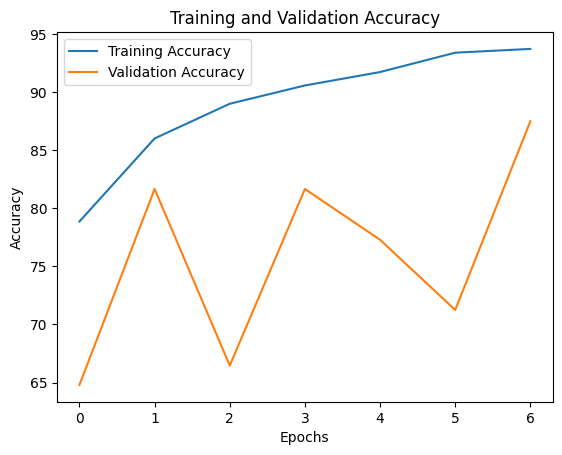

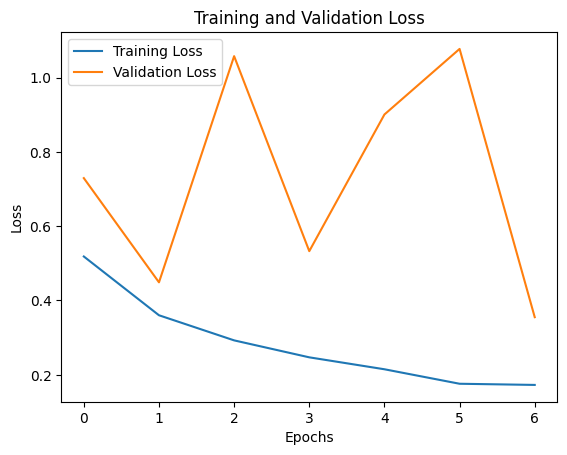

In [24]:
import matplotlib.pyplot as plt

# Function for plotting
def plot_metrics(train_metric, val_metric, metric_name):
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

# Plotting the accuracy
plot_metrics(train_accuracies, val_accuracies, 'Accuracy')

# Plotting the loss
plot_metrics(train_losses, val_losses, 'Loss')